In [13]:
import timeit
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from functools import reduce
import operator

In [12]:
from jax import tree_util
from graphax.sparse.block import BlockSparseTensor

def flatten_block_sparse_tensor(tensor):
    children = (tensor.blocks,)
    aux_data = (tensor.out_dims, tensor.primal_dims, tensor.pre_transforms, tensor.post_transforms)
    return children, aux_data

def unflatten_block_sparse_tensor(aux_data, children):
    blocks, = children
    out_dims, primal_dims, pre_transforms, post_transforms = aux_data
    return BlockSparseTensor(out_dims, primal_dims, blocks, pre_transforms, post_transforms)

tree_util.register_pytree_node(BlockSparseTensor, flatten_block_sparse_tensor, unflatten_block_sparse_tensor)

ValueError: Duplicate custom PyTreeDef type registration for <class 'graphax.sparse.block.BlockSparseTensor'>.

In [66]:
from jax import jit, make_jaxpr
from graphax.sparse.block import BlockSparseTensor, SparseDimension
import jax.random as jrand

# Example setup
block_nums = 100
block_size = 100
k1, k2 = jrand.split(jrand.PRNGKey(42), 2)
x_blocks = jrand.normal(k1, (block_nums, block_size, block_size))
y_blocks = jrand.normal(k2, (block_nums, block_size, block_size))
x = BlockSparseTensor([SparseDimension(0, block_nums, 0, 1)], [SparseDimension(1, block_nums, 0, 0)], x_blocks)
y = BlockSparseTensor([SparseDimension(0, block_nums, 0, 1)], [SparseDimension(1, block_nums, 0, 0)], y_blocks)

# Define the matmul function for BlockSparseTensor
def matmul(a, b):
    return a @ b

# JIT compile the matmul function
jit_matmul = jit(matmul, static_argnums=(0, 1))

# Generate the JAXPR
jaxpr = make_jaxpr(jit_matmul)(x, y)
print(jaxpr)

TypeError: Error interpreting argument to <PjitFunction of <function matmul at 0x10dea0860>> as an abstract array. The problematic value is of type <class 'graphax.sparse.block.BlockSparseTensor'> and was passed to the function at path a.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [14]:
import json
import os
import ast

res = {}
for run in os.listdir('data'):
    with open('data/' + run, "r") as f:
        res2 = json.load(f)
    
    for key1, val1 in list(res2.items()):
        key1 = ast.literal_eval(key1)
        if key1 not in res:
            res[key1] = {}
        
        for key2, val2 in list(val1.items()):
            key2 = ast.literal_eval(key2)
            if key2 not in res[key1]:
                res[key1][key2] = {}
            
            for key3, val3 in list(val2.items()):
                if key3 not in res[key1][key2]:
                    if key3.endswith('_mul_sum'):
                        val3 = tuple(val3)
                    res[key1][key2][key3] = val3

In [76]:
from datetime import datetime
with open(f'data/{datetime.today()}.json', "w") as f:
    json.dump(res, f, indent=4)

In [15]:
last_layer_keys = next(iter(next(iter(res.values())).values())).keys()
mul_sum_keys = set(key for key in last_layer_keys if key.endswith('mul_sum'))
exp_data_keys = last_layer_keys - mul_sum_keys
stat_operator = np.median

In [16]:
# Test memory at some point maybe even test time
# Test on CPU

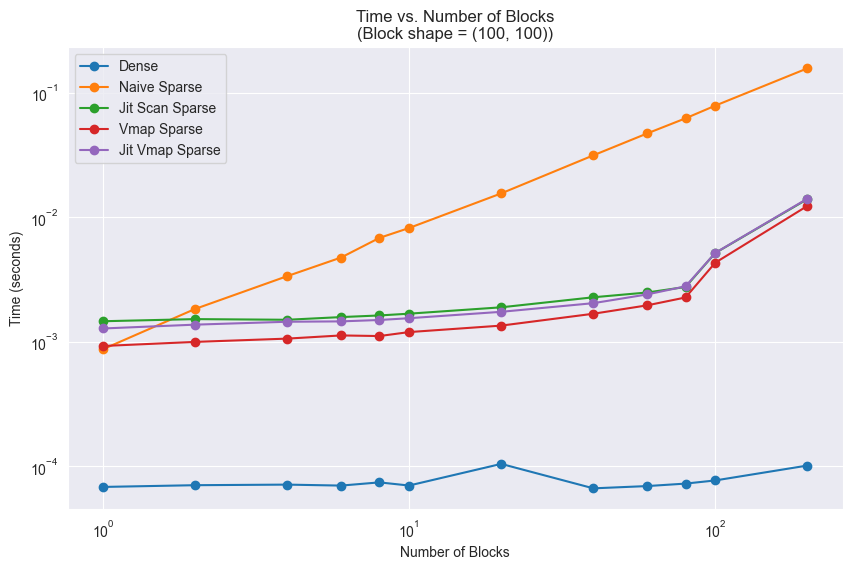

In [17]:
block_shape_to_plot = (100, 100)
blocks = []
times = {key: [] for key in exp_data_keys}

for non_block_shape, block_shapes in res.items():
    if block_shape_to_plot in block_shapes:
        blocks.append(reduce(operator.mul, non_block_shape))
        for key in exp_data_keys:
            times[key].append(stat_operator(block_shapes[block_shape_to_plot][key]))

plt.figure(figsize=(10, 6))

for key in exp_data_keys:
    plt.plot(blocks, times[key], marker='o', label=key.replace('_', ' ').title())

plt.xlabel("Number of Blocks")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Number of Blocks\n(Block shape = {block_shape_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

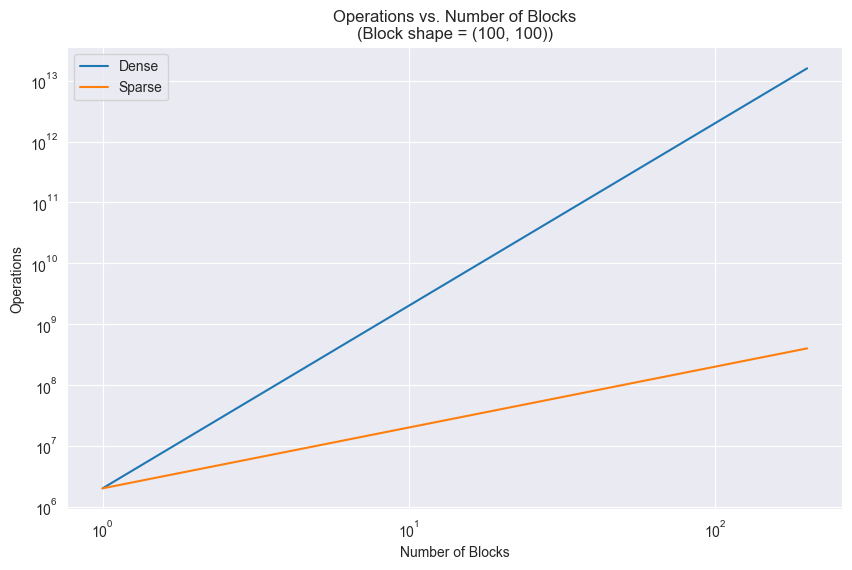

In [18]:
block_shape_to_plot = (100,100)
blocks = []
times = {key: [] for key in mul_sum_keys}

for non_block_shape, block_shapes in res.items():
    if block_shape_to_plot in block_shapes:
        blocks.append(reduce(operator.mul, non_block_shape))
        for key in mul_sum_keys:
            times[key].append(np.sum(block_shapes[block_shape_to_plot][key]))

plt.figure(figsize=(10, 6))

for key in mul_sum_keys:
    plt.plot(blocks, times[key], label=key.split('_',2)[0].title())

plt.xlabel("Number of Blocks")
plt.ylabel("Operations")
plt.title(f"Operations vs. Number of Blocks\n(Block shape = {block_shape_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

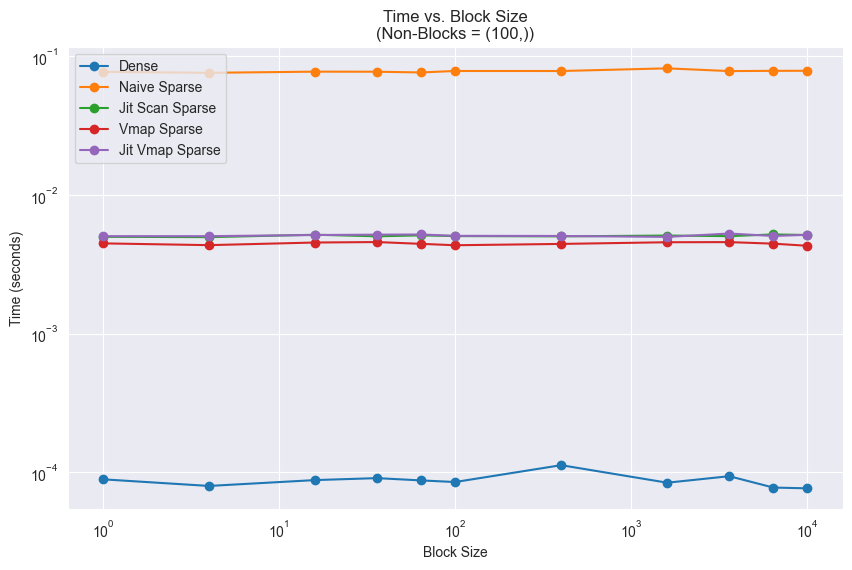

In [19]:
non_block_shape_to_plot = (100,)
blocks = []
times = {key: [] for key in exp_data_keys}

if non_block_shape_to_plot in res:
    block_shapes = res[non_block_shape_to_plot]
    for block_shape in block_shapes:
        blocks.append(reduce(operator.mul, block_shape))
        for key in exp_data_keys:
            times[key].append(stat_operator(block_shapes[block_shape][key]))


plt.figure(figsize=(10, 6))

for key in exp_data_keys:
    plt.plot(blocks, times[key], marker='o', label=key.replace('_', ' ').title())
    
plt.xlabel("Block Size")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Block Size\n(Non-Blocks = {non_block_shape_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

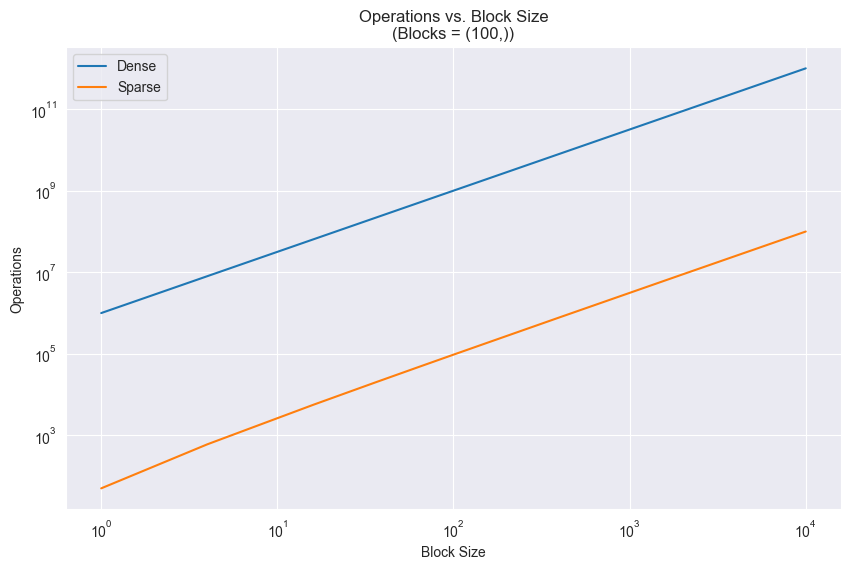

In [20]:
non_block_shape_to_plot = (100,)
blocks = []
times = {key: [] for key in mul_sum_keys}

if non_block_shape_to_plot in res:
    block_shapes = res[non_block_shape_to_plot]
    for block_shape in block_shapes:
        blocks.append(reduce(operator.mul, block_shape))
        for key in mul_sum_keys:
            times[key].append(stat_operator(block_shapes[block_shape][key]))


plt.figure(figsize=(10, 6))

for key in mul_sum_keys:
    plt.plot(blocks, times[key], label=key.split('_',2)[0].title())
    
plt.xlabel("Block Size")
plt.ylabel("Operations")
plt.title(f"Operations vs. Block Size\n(Blocks = {non_block_shape_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

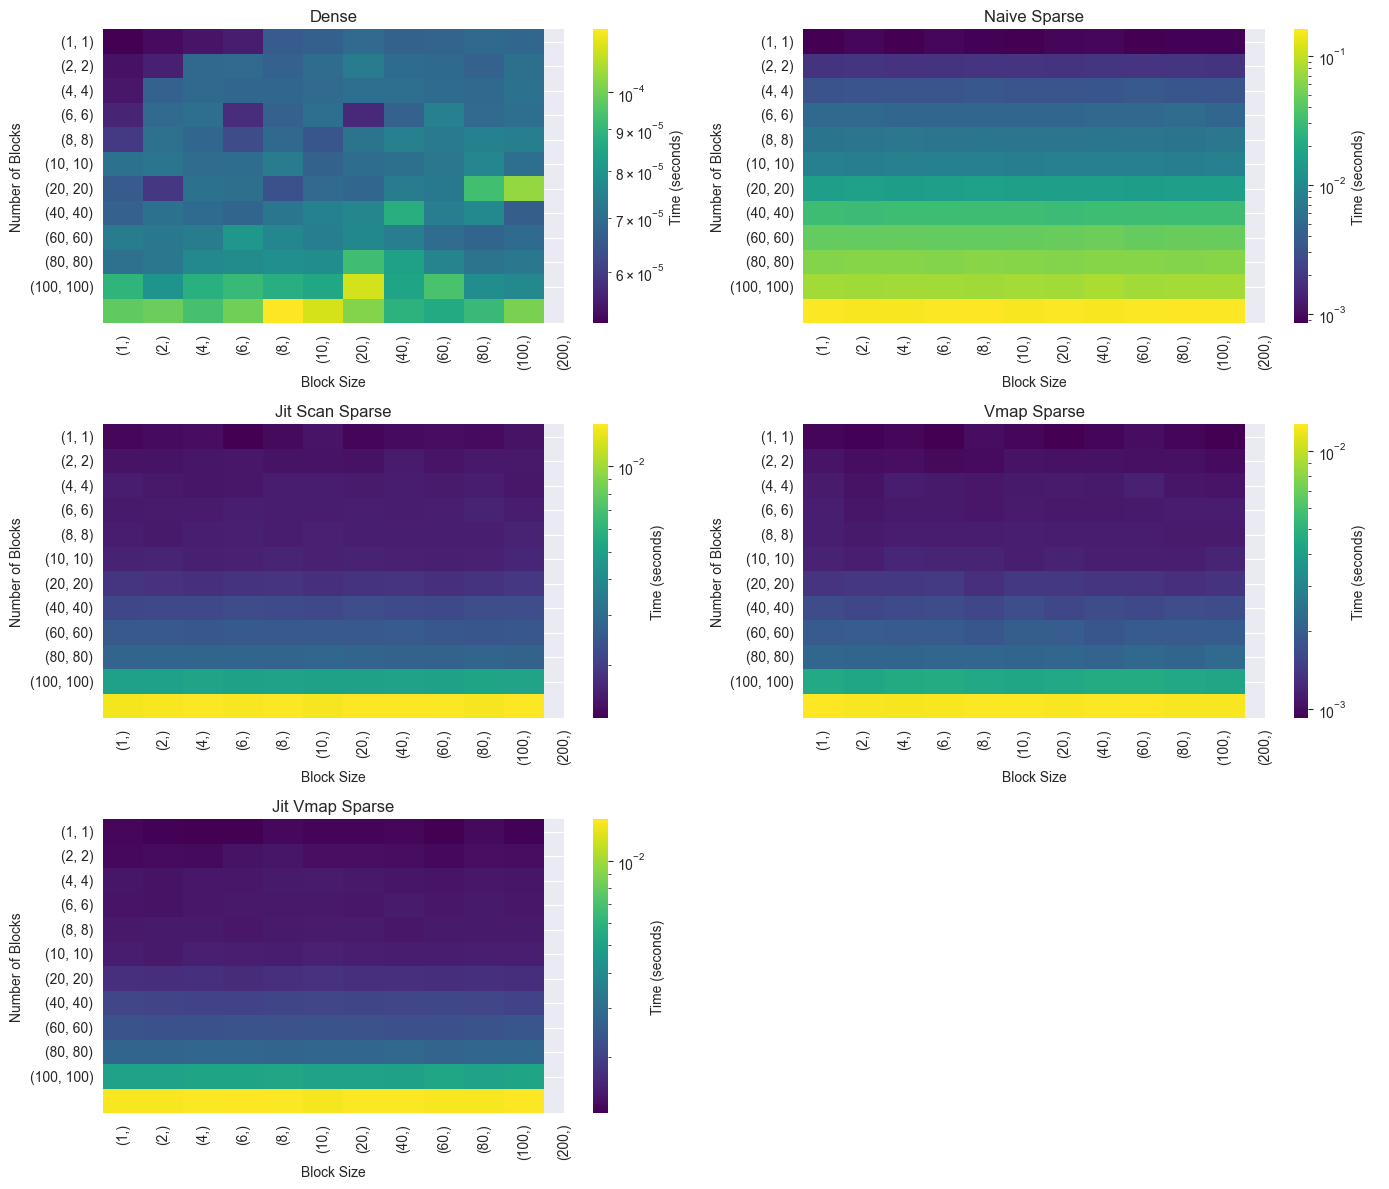

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = {key: [] for key in exp_data_keys}   
non_block_shapes_labels = sorted(res.keys())
block_shapes_labels = sorted(next(iter(res.values())).keys())

for non_block_shapes in non_block_shapes_labels:
    rows = {key: [] for key in exp_data_keys}
    for block_shape in block_shapes_labels:
        for key in exp_data_keys:
            rows[key].append(stat_operator(res[non_block_shapes][block_shape][key]))
    for key in exp_data_keys:
        heatmap_data[key].append(rows[key])
for key in exp_data_keys:
    heatmap_data[key] = np.array(heatmap_data[key])
    
fig, axes = plt.subplots(-(len(exp_data_keys)//-2), 2, figsize=(14, 12))

vmax = min([np.quantile(heatmap_data[key], 0.8) for key in exp_data_keys])
vmin = max([np.quantile(heatmap_data[key], 0.2) for key in exp_data_keys])

for i, key in enumerate(exp_data_keys):
    sns.heatmap(
        heatmap_data[key],
        ax=axes[i // 2, i % 2],
        xticklabels=non_block_shapes_labels,
        yticklabels=block_shapes_labels,
        vmin=vmin,
        vmax=vmax,
        norm=plt.matplotlib.colors.LogNorm(),
        cmap="viridis",
        cbar_kws={"label": "Time (seconds)"}
    )
    axes[i // 2, i % 2].set_xlabel("Block Size")
    axes[i // 2, i % 2].set_ylabel("Number of Blocks")
    axes[i // 2, i % 2].set_title(key.replace('_', ' ').title())

if len(exp_data_keys) % 2:
    axes[-(len(exp_data_keys)//-2) - 1, 1].axis('off')

plt.tight_layout()

plt.show()

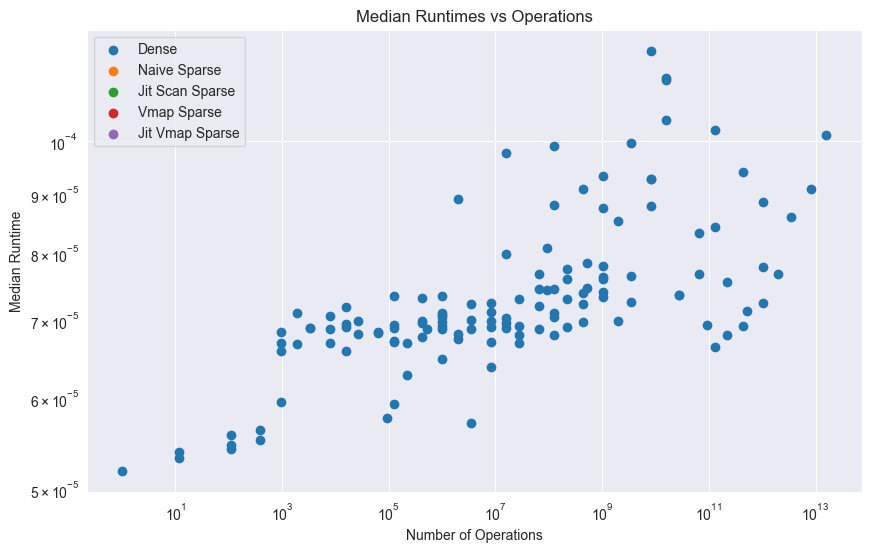

In [22]:
data = {key: {'time': [], 'ops': []} for key in exp_data_keys}   
for key1, val1 in res.items():
    for key2, val2 in val1.items():
        for key3 in exp_data_keys:
            if key3.endswith('sparse'):
                if 'sparse_mul_sum' in val2:
                    continue
            if key3.endswith('sparse'):
                ops = sum(val2['sparse_mul_sum'])
            else:
                ops = sum(val2['dense_mul_sum'])
            data[key3]['ops'].append(ops)
            data[key3]['time'].append(stat_operator(val2[key3]))

plt.figure(figsize=(10, 6))

for key in exp_data_keys:
    plt.scatter(data[key]['ops'], data[key]['time'], label=key.replace('_',' ').title(), marker="o")

# Customize the plot
plt.title("Median Runtimes vs Operations")
plt.xlabel("Number of Operations")
plt.ylabel("Median Runtime")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()